In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from useful_functions import *
import seaborn as sns
from config_path import MS_DATA_PATH
print(MS_DATA_PATH)

Base path: ..
../data/ms


In [2]:


df = pd.read_csv(f'{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv(f'{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values

print(len(GroupOneCols))
print(len(GroupTwoCols))

30
42


### Peptide distribution in samples

In [3]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'# unique proteins: {nr_unique_proteins} ')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['PeptideCountSum'] = df['PeptideCount1']+df['PeptideCount2']
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)
df['FC'] = df['IntensityMean1'] / df['IntensityMean2']
df['IntensitySum'] = df['IntensitySum1'] + df['IntensitySum2']


# unique proteins: 1039 


In [8]:
# Histogram of peptides per protein
protein_peptide_count = df.groupby('Protein', as_index=False).sum()[['Protein','PeptideCount1','PeptideCount2','PeptideCountSum']]

groupratio = len(GroupOneCols)/len(GroupTwoCols)
protein_peptide_count = protein_peptide_count.sort_values('PeptideCountSum',ascending=False)
df1 = protein_peptide_count[['Protein','PeptideCount1']]
df2 = protein_peptide_count[['Protein', 'PeptideCount2']]
df1 = df1.rename(columns={'PeptideCount1':'PeptideCount'})
df2 = df2.rename(columns={'PeptideCount2':'PeptideCount'})
df1['Group'] = 1
df2['Group'] = 2
df2['PeptideCount'] = df2['PeptideCount'] * groupratio
df1['i'] = range(len(df1.index))
df2['i'] = range(len(df2.index))
df_new = pd.concat([df1,df2])
plt.rcParams["figure.figsize"] = (4,3)
plt.bar(x=df1['i'].values, height=df1['PeptideCount'].values,align='edge', alpha=0.3, width=1.0,color='red', label='Group 1')
plt.bar(x=df2['i'].values, height=df2['PeptideCount'].values,align='edge', alpha=0.3,width=1.0, color='blue', label='Group 2')

reduction_factor =  25

plt.scatter(x=range(len(df1['Protein'])), y=df1['PeptideCount'].cumsum()/reduction_factor, alpha=0.3, marker='^', color='red')
plt.scatter(x=range(len(df1['Protein'])), y=df2['PeptideCount'].cumsum()/reduction_factor,alpha=0.3,  marker = 'v', color='blue')
print('Sum1: ', df['PeptideCount1'].sum())
print('Sum2: ', df['PeptideCount2'].sum())
plt.xticks([])
plt.xscale('log')
plt.xlabel('Proteins')
plt.ylabel('Number of peptides')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig('../plots/general/PeptideCount.jpg', dpi=300)

Sum1:  107377
Sum2:  154532


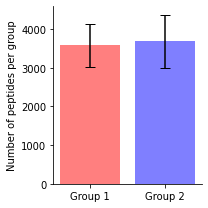

In [288]:
# Peptides per protein
group1_peptides = []
for col in GroupOneCols:
    group1_peptides.append(df[col].count())
group1_mean =  np.mean(group1_peptides)
group1_sd = np.std(group1_peptides)
group2_peptides = []
for col in GroupTwoCols:
    group2_peptides.append(df[col].count())
group2_mean = np.mean(group2_peptides)
group2_sd = np.std(group2_peptides)
plt.rcParams["figure.figsize"] = (3,3)
plt.bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
plt.ylabel('Number of peptides per group')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('../plots/general/PeptidesPerGroupBar.jpg', dpi=300)

/tmp/ipykernel_17439/2825480333.py:10: RuntimeWarning: divide by zero encountered in log10
  df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]


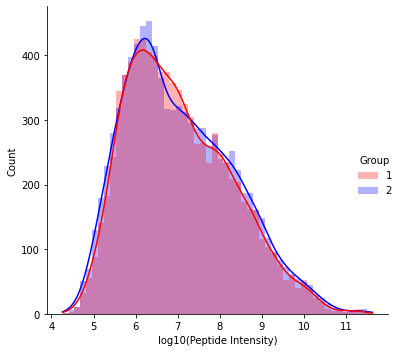

In [291]:
df1 = df[['PeptideSequence','IntensitySum1']]
df2 = df[['PeptideSequence', 'IntensitySum2']]
df1 = df1.rename(columns={'IntensitySum1':'IntensitySum'})
df2 = df2.rename(columns={'IntensitySum2':'IntensitySum'})
df1['Group'] = 1
df2['Group'] = 2

df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)
df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]

sns.displot(data=df_new, kde=True, x= 'logI', hue='Group', edgecolor=None, palette=['red','blue'], alpha=0.3)
plt.xlabel('log10(Peptide Intensity)')
plt.tight_layout()
plt.savefig('../plots/general/PeptideIntensityHistogram.jpg', dpi=300)

### Differential expression
Peptide Level:

In [217]:
df['pvalue'] = df.apply(lambda x: get_p_value(x, GroupOneCols, GroupTwoCols), axis=1)
df['Log2FoldChange1-2'] = [np.log2(x) for x in df['FC']]
df['logPValue'] = y=[-np.log(val) for val in df['pvalue'].values]
df['color'] = df.apply(lambda x: color_if_significant(x), axis=1)
plt.scatter(x=df['Log2FoldChange1-2'].values , y=df['logPValue'].values, color=df['color'].values, alpha=0.3)
plt.vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
plt.hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
plt.title('Peptide differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')
plt.tight_layout()
plt.savefig('../plots/general/PeptideVolcano.jpg', dpi=300)

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=

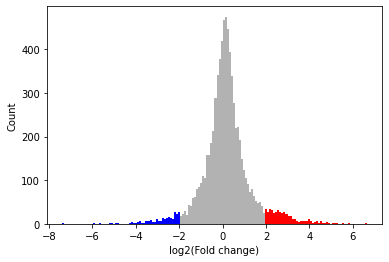

In [227]:
g = sns.histplot(df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0)
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')
plt.xlabel('log2(Fold change)')
plt.savefig('../plots/general/PeptideFCHistogram.jpg', dpi=300)

### Protein level

## DPKS
---

In [3]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv"
)

compare_df = (
        quant_matrix
        .filter() # filter for q-values (removes rows with low q value (peptides), Q = 0.01) and removes decoys
        .normalize(method="mean", use_rt_sliding_window_filter = True) # best type of normalization is RT-sliding window
        .quantify(method="maxlfq") # play around with minimum_subgroups (default is set 1)
    ).compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df()
compare_df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


Protein  Group1Mean  Group2Mean  Log2FoldChange1-2  PValues1-2  \
0     P06396   21.288717   21.226708           0.062010    0.694861   
1     P10643   21.516173   21.613422          -0.097249    0.503560   
2     P03952   20.936229   20.612498           0.323731    0.045767   
3     P02750   23.510573   23.954318          -0.443745    0.003362   
4     Q04756   19.586920   18.838137           0.748783    0.000072   
...      ...         ...         ...                ...         ...   
1034  P01275         NaN         NaN                NaN         NaN   
1035  P16104         NaN         NaN                NaN         NaN   
1036  O00194         NaN         NaN                NaN         NaN   
1037  Q6R327         NaN         NaN                NaN         NaN   
1038  Q15056   21.893805   22.070760          -0.176955    0.761641   

      Group1RepCounts  Group2RepCounts  CorrectedPValue  TM_M2012_010  \
0                  30               42         0.721447     21.690603   
1                  30               42         0.625305     21.677649   
2                  30               42         0.149304     21.023477   
3                  30               42         0.023420     22.807610   
4                  30               41         0.001191     19.657972   
...               ...              ...              ...           ...   
1034                0                1              NaN           NaN   
1035                0                1              NaN           NaN   
1036                0                0              NaN           NaN   
1037                0                0              NaN           NaN   
1038                8                9         0.752814           NaN   

      TM_M2012_011  ...  TM_M2012_177  TM_M2012_178  TM_M2012_182  \
0        20.691873  ...     20.419413     21.028937     21.542064   
1        21.190349  ...     21.893203     21.188014     21.371173   
2        20.770036  ...     20.505599     20.608387     20.970957   
3        23.269826  ...     23.784981     24.566548     24.806581   
4        19.115191  ...     18.220235     18.721893     18.931209   
...            ...  ...           ...           ...           ...   
1034           NaN  ...           NaN           NaN           NaN   
1035           NaN  ...           NaN           NaN           NaN   
1036           NaN  ...           NaN           NaN           NaN   
1037           NaN  ...           NaN           NaN           NaN   
1038           NaN  ...           NaN           NaN           NaN   

      TM_M2012_183  TM_M2012_186  TM_M2012_188  TM_M2012_189  TM_M2012_196  \
0        21.509333     21.198022     21.245511     21.200419     23.029393   
1        21.436145     21.356409     21.040272     21.362647     21.331875   
2        20.752389     21.042518     20.957229     21.163873     22.332772   
3        24.787613     22.859750     22.901881     23.686287     24.103840   
4        18.973254     19.296811     18.608288     19.034313     20.708523   
...            ...           ...           ...           ...           ...   
1034           NaN           NaN           NaN           NaN           NaN   
1035           NaN           NaN           NaN           NaN           NaN   
1036           NaN           NaN           NaN           NaN           NaN   
1037           NaN           NaN           NaN           NaN           NaN   
1038           NaN           NaN           NaN           NaN     22.755072   

      TM_M2012_197  TM_M2012_198  
0        23.389134     23.470304  
1        21.524378     21.930228  
2        22.704704     22.773377  
3        23.764547     24.052968  
4        20.283616     20.454671  
...            ...           ...  
1034           NaN           NaN  
1035           NaN     19.966682  
1036           NaN           NaN  
1037           NaN           NaN  
1038           NaN           NaN  

[1039 rows x 80 columns]

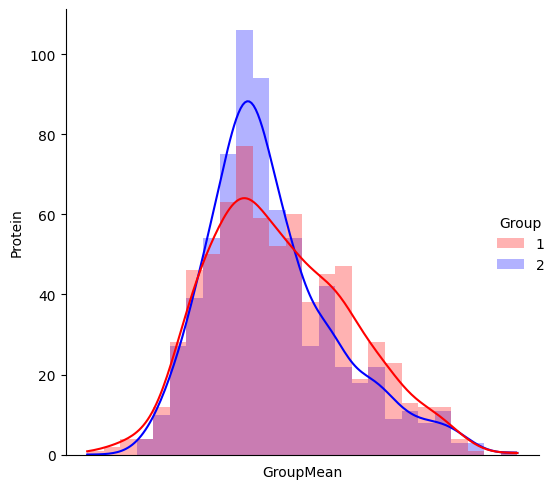

In [12]:
df1 = compare_df[['Protein','Group1Mean']]
df2 = compare_df[['Protein', 'Group2Mean']]
df1 = df1.rename(columns={'Group1Mean':'GroupMean'})
df2 = df2.rename(columns={'Group2Mean':'GroupMean'})
df1['Group'] = 1
df2['Group'] = 2

df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)
sns.displot(data=df_new, kde=True, x= 'GroupMean', hue='Group', edgecolor=None, palette=['red','blue'], alpha=0.3)

plt.xticks([])
plt.ylabel('Protein')
plt.tight_layout()
#plt.savefig('../plots/general/ProteinMeanAbundanceHistogram.jpg', dpi=300)

592    P25787
219    P25788
535    P07711
576    P28066
384    P00390
Name: Protein, dtype: object
1031    P55083
1034    P01275
1035    P16104
1036    O00194
1037    Q6R327
Name: Protein, dtype: object


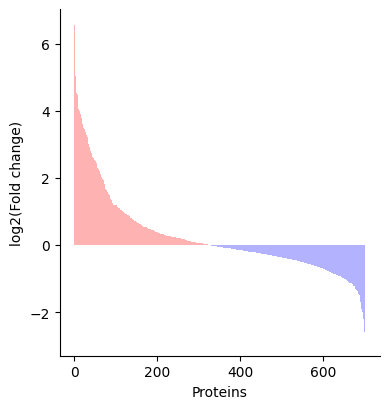

In [38]:
compare_df = compare_df.sort_values('Log2FoldChange1-2', ascending=False)
print(compare_df[0:5].Protein)
print(compare_df[len(compare_df.index)-5:len(compare_df.index)].Protein)
plt.rcParams["figure.figsize"] = (4,4)
g = plt.bar(x=range(len(compare_df.index)), height=compare_df['Log2FoldChange1-2'], align='edge', alpha=0.3, width=1.0,color='red', label='Group 1')
for p in range(len(g.patches)):
    height = g.patches[p].get_height()
    
    if height < 0 :
        g.patches[p].set_facecolor('blue')
    elif height > 0:
        g.patches[p].set_facecolor('red')
sns.despine()
plt.ylabel('log2(Fold change)')
plt.tight_layout()
plt.xlabel('Proteins')
plt.savefig('../plots/general/FCBar.jpg', dpi=300)


In [311]:
def color_if_significant(row):
    if row['logPValue'] > 1.31 and row['Log2FoldChange1-2'] < -1.2:
        return 'blue'
    if row['logPValue'] > 1.31 and row['Log2FoldChange1-2'] > 1.2:
        return 'red'
    return 'black'

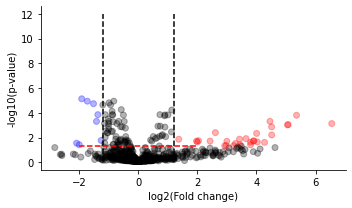

In [312]:
compare_df['logPValue'] = -1.0 * np.log10(compare_df['CorrectedPValue'])
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)
plt.scatter(x=compare_df['Log2FoldChange1-2'], y=compare_df['logPValue'], color=compare_df['color'].values, alpha=0.3)
plt.rcParams["figure.figsize"] = (5,3)
plt.vlines(1.2, ymin=0, ymax=12, color='black', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='black', linestyle='dashed')
plt.hlines(1.31, xmin=-2, xmax=2, color='red', linestyle='dashed')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Fold change)')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('../plots/general/ProteinVolcano.jpg', dpi=300)

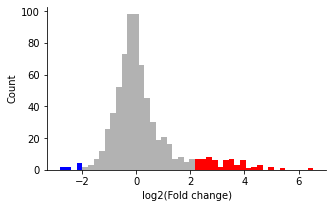

In [313]:
plt.rcParams["figure.figsize"] = (5,3)
g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0)
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')
plt.xlabel('log2(Fold change)')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig('../plots/general/ProteinFCHistogram.jpg', dpi=300)

In [314]:
quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv"
)

compare_df = (quant_matrix.filter().normalize(method="mean", use_rt_sliding_window_filter = True)).compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='precursor',
    ).to_df()
compare_df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


PeptideSequence  Charge  Decoy  \
0                                             KGGVASGFK       2      0   
1                                   MHVLHC(UniMod:4)QGR       3      0   
2                                            TGAVSGHSLK       2      0   
3                                               LHLEGNK       2      0   
4                               MLHAC(UniMod:4)TSEGSAHR       4      0   
...                                                 ...     ...    ...   
13370                               FDLGQDVIDFTGHALALYR       2      0   
13371  VFDEFKPLVEEPQNLIKQNC(UniMod:4)ELFEQLGEYKFQNALLVR       4      0   
13372                            EFYLFPTVFDENESLLLEDNIR       3      0   
13373                                  DMALTAFVLISLQEAK       2      0   
13374                                    ISGSILNELIGLVR       3      0   

      Protein  RetentionTime  PeptideQValue  ProteinQValue  \
0      P06396        685.798       0.000000            0.0   
1      P10643        702.533       0.000000            0.0   
2      P03952        702.600       0.000000            0.0   
3      P02750        716.333       0.000000            0.0   
4      Q04756        732.411       0.000000            0.0   
...       ...            ...            ...            ...   
13370  P31150       6037.035       0.000214            0.0   
13371  P02768       6037.100       0.000000            0.0   
13372  P00450       6037.695       0.000000            0.0   
13373  P01024       6038.920       0.000000            0.0   
13374  Q86VP6       6047.880       0.001439            0.0   

                                             PrecursorId  Group1Mean  \
0                                            KGGVASGFK_2   18.989198   
1                                  MHVLHC(UniMod:4)QGR_3   21.624927   
2                                           TGAVSGHSLK_2   19.388518   
3                                              LHLEGNK_2   22.247049   
4                              MLHAC(UniMod:4)TSEGSAHR_4         NaN   
...                                                  ...         ...   
13370                              FDLGQDVIDFTGHALALYR_2         NaN   
13371  VFDEFKPLVEEPQNLIKQNC(UniMod:4)ELFEQLGEYKFQNALL...         NaN   
13372                           EFYLFPTVFDENESLLLEDNIR_3         NaN   
13373                                 DMALTAFVLISLQEAK_2         NaN   
13374                                   ISGSILNELIGLVR_3         NaN   

       Group2Mean  ...  TM_M2012_177  TM_M2012_178  TM_M2012_182  \
0       19.164162  ...           NaN     19.740344     19.376169   
1       21.320765  ...           NaN     20.893909     21.495066   
2       19.111947  ...           NaN           NaN     19.318540   
3       22.730798  ...           NaN     23.663179     23.454860   
4             NaN  ...           NaN           NaN           NaN   
...           ...  ...           ...           ...           ...   
13370         NaN  ...           NaN           NaN           NaN   
13371         NaN  ...           NaN           NaN           NaN   
13372         NaN  ...           NaN           NaN           NaN   
13373         NaN  ...           NaN           NaN           NaN   
13374         NaN  ...           NaN           NaN           NaN   

       TM_M2012_183  TM_M2012_186  TM_M2012_188  TM_M2012_189  TM_M2012_196  \
0         18.952661           NaN     18.350601     18.080521           NaN   
1         21.461510           NaN     19.871855           NaN           NaN   
2               NaN           NaN     18.059342           NaN           NaN   
3         23.264612           NaN     20.482940           NaN           NaN   
4               NaN           NaN           NaN           NaN           NaN   
...             ...           ...           ...           ...           ...   
13370           NaN           NaN           NaN           NaN           NaN   
13371           NaN           NaN           NaN           NaN           NaN   
13372        

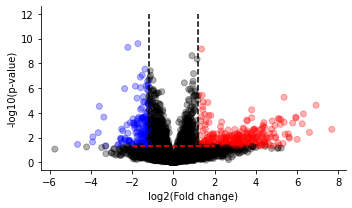

In [315]:
compare_df['logPValue'] = -1.0 * np.log10(compare_df['PValues1-2'])
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)
plt.rcParams["figure.figsize"] = (5,3)
plt.scatter(x=compare_df['Log2FoldChange1-2'], y=compare_df['logPValue'], color=compare_df['color'].values, alpha=0.3)

plt.vlines(1.2, ymin=0, ymax=12, color='black', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='black', linestyle='dashed')
plt.hlines(1.31, xmin=-2, xmax=2, color='red', linestyle='dashed')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Fold change)')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('../plots/general/PrecursorVolcano.jpg', dpi=300)

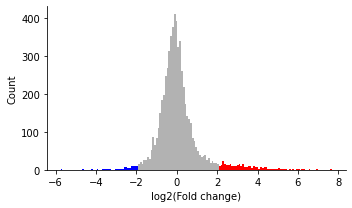

In [320]:
plt.rcParams["figure.figsize"] = (5,3)
g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0)
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

plt.xlabel('log2(Fold change)')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('../plots/general/PrecursorFCHistogram.jpg',  dpi=300)